In [ ]:
!pip install librosa scikit-learn matplotlib seaborn


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import librosa
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# Device handling
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# Emotion labels (match folder names)
EMOTIONS = ['Boredom', 'Panic', 'Excitement', 'Uncertainity']

EMOTION_TO_IDX = {emo: i for i, emo in enumerate(EMOTIONS)}

# Google Drive Paths for training dataset
TRAIN_DIR = "/content/drive/MyDrive/EmotionData/train/"
#TRAIN_DIR = "/content/drive/MyDrive/CMPT_419_2025/EmotionData/train/"


# Audio settings
SAMPLE_RATE = 16000
MAX_LEN = 1000  # For padding MFCC sequences (around 10 seconds of audio)

In [ ]:
def extract_mfcc_sequence(file_path, max_len=MAX_LEN):
    y, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    # Extract MFCC and its first and second derivatives
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=25)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)

    features = np.vstack([mfcc, delta, delta2])  # (75, T)

    # Normalize each feature
    features = (features - np.mean(features, axis=1, keepdims=True)) / (np.std(features, axis=1, keepdims=True) + 1e-8)

    # Pad or truncate
    if features.shape[1] < max_len:
        pad = max_len - features.shape[1]
        features = np.pad(features, ((0, 0), (0, pad)), mode='constant')
    else:
        features = features[:, :max_len]

    return features.T  # Did transpose (T, 75)


In [ ]:
class EmotionSequenceDataset(Dataset):
    def __init__(self, base_dir, print_logs=False):
        self.data = []
        self.labels = []
        for emotion in EMOTIONS:
            folder = os.path.join(base_dir, emotion.capitalize())
            for filename in os.listdir(folder):
                if filename.endswith(".wav"):
                    path = os.path.join(folder, filename)
                    features = extract_mfcc_sequence(path)
                    label = EMOTION_TO_IDX[emotion]
                    self.data.append((features, label))
                    self.labels.append(label)
                    if print_logs:
                        print(f"Loaded: {filename} → {emotion}")

        if print_logs:
            counts = Counter(self.labels)
            print("\nClass distribution:")
            for k, v in counts.items():
                print(f"{EMOTIONS[k]}: {v} samples")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features, label = self.data[idx]
        return torch.tensor(features, dtype=torch.float32), label


In [ ]:
# Multi-scale CNN block to capture features at different time resolutions
class MultiScaleCNN(nn.Module):
    def __init__(self, input_dim=75, out_channels=64):
        super(MultiScaleCNN, self).__init__()
        self.conv3 = nn.Conv1d(input_dim, out_channels, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(input_dim, out_channels, kernel_size=5, padding=2)
        self.conv7 = nn.Conv1d(input_dim, out_channels, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(out_channels * 3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # x shape: (batch, channels, time)
        x3 = self.relu(self.conv3(x))
        x5 = self.relu(self.conv5(x))
        x7 = self.relu(self.conv7(x))
        # Concatenate along the channel dimension
        x_cat = torch.cat([x3, x5, x7], dim=1)
        x_cat = self.bn(x_cat)
        x_cat = self.dropout(x_cat)
        return x_cat  # shape: (batch, out_channels*3, time)

# Simple self-attention mechanism to focus on important temporal features
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(input_dim, input_dim)
        self.key   = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # x shape: (batch, seq, input_dim)
        Q = self.query(x)  # (batch, seq, input_dim)
        K = self.key(x)    # (batch, seq, input_dim)
        V = self.value(x)  # (batch, seq, input_dim)
        # Compute attention scores
        scores = torch.bmm(Q, K.transpose(1, 2)) / np.sqrt(x.size(-1))
        attn_weights = self.softmax(scores)
        attn_output = torch.bmm(attn_weights, V)
        # Residual connection adds the original input back in
        return attn_output + x

In [ ]:
# Enhanced model inspired by wav2vec: multi-scale CNN -> BiLSTM -> Self-Attention -> FC layers
class EnhancedEmotionModel(nn.Module):
    def __init__(self, input_dim=75, hidden_dim=128, num_classes=len(EMOTIONS)):
        super(EnhancedEmotionModel, self).__init__()
        self.multi_cnn = MultiScaleCNN(input_dim=input_dim, out_channels=64)  # Output channels: 64*3 = 192
        self.lstm = nn.LSTM(192, hidden_dim, num_layers=2, batch_first=True, bidirectional=True)
        self.attention = SelfAttention(hidden_dim * 2)  # Input dimension: hidden_dim * 2 (bidirectional)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x shape: (batch, time, features)
        x = x.permute(0, 2, 1)  # shape becomes (batch, features, time)
        x = self.multi_cnn(x)   # (batch, 192, time)
        x = x.permute(0, 2, 1)   # (batch, time, 192)
        lstm_out, _ = self.lstm(x)  # (batch, time, hidden_dim*2)
        attn_out = self.attention(lstm_out)  # (batch, time, hidden_dim*2)
        pooled = torch.mean(attn_out, dim=1)  # Global average pooling over time
        return self.fc(pooled)

In [ ]:
#Load Entire Dataset for Training Only
dataset = EmotionSequenceDataset(TRAIN_DIR)

# Compute class weights
labels = [label for _, label in dataset]

train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [ ]:
#Training Loop

model = EnhancedEmotionModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
num_epoch = 15

for epoch in range(num_epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for features, labels in train_loader:
        features = features.to(device)
        labels = torch.tensor(labels).to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    scheduler.step()
    acc = correct / total
    print(f"Epoch {epoch+1} | Loss: {total_loss:.4f} | Training Accuracy: {acc:.3f}")

<ipython-input-15-283f312b9158>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels).to(device)


Epoch 1 | Loss: 43.1227 | Training Accuracy: 0.240
Epoch 2 | Loss: 33.7692 | Training Accuracy: 0.475
Epoch 3 | Loss: 27.4931 | Training Accuracy: 0.537
Epoch 4 | Loss: 27.4573 | Training Accuracy: 0.492
Epoch 5 | Loss: 23.3894 | Training Accuracy: 0.529
Epoch 6 | Loss: 19.4889 | Training Accuracy: 0.711
Epoch 7 | Loss: 23.5183 | Training Accuracy: 0.645
Epoch 8 | Loss: 16.0848 | Training Accuracy: 0.744
Epoch 9 | Loss: 12.3040 | Training Accuracy: 0.814
Epoch 10 | Loss: 14.6821 | Training Accuracy: 0.789
Epoch 11 | Loss: 16.7312 | Training Accuracy: 0.839
Epoch 12 | Loss: 8.5771 | Training Accuracy: 0.921
Epoch 13 | Loss: 5.5084 | Training Accuracy: 0.938
Epoch 14 | Loss: 3.7768 | Training Accuracy: 0.971
Epoch 15 | Loss: 3.7168 | Training Accuracy: 0.983



 Validation Results (on val/):
Accuracy     : 0.453
Precision    : 0.494
Recall       : 0.455
F1 Score     : 0.436


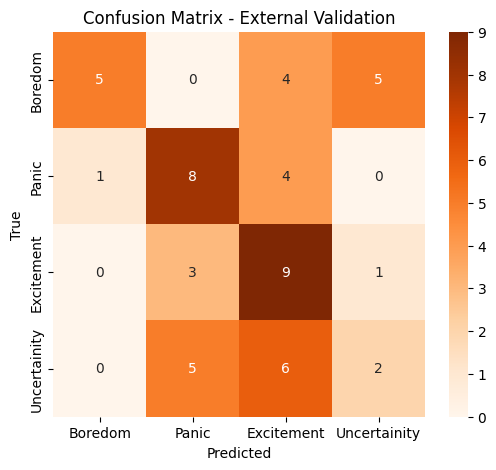

In [ ]:
# Validation on External Dataset (val/)
VAL_DIR = "/content/drive/MyDrive/EmotionData/val/"
#VAL_DIR = "/content/drive/MyDrive/CMPT_419_2025/EmotionData/val/"
val_dataset = EmotionSequenceDataset(VAL_DIR)
val_loader = DataLoader(val_dataset, batch_size=8)

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for features, labels in val_loader:
        features = features.to(device)
        outputs = model(features)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_true.extend(labels)
        y_pred.extend(preds)

# Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print("\n Validation Results (on val/):")
print("Accuracy     :", round(accuracy_score(y_true, y_pred), 3))
print("Precision    :", round(precision_score(y_true, y_pred, average='macro'), 3))
print("Recall       :", round(recall_score(y_true, y_pred, average='macro'), 3))
print("F1 Score     :", round(f1_score(y_true, y_pred, average='macro'), 3))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, xticklabels=EMOTIONS, yticklabels=EMOTIONS, fmt='d', cmap='Oranges')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - External Validation")
plt.show()


 Starting 7-Fold Cross Validation

 Fold 1/7


<ipython-input-14-e2e06f2136ad>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features, labels = features.to(device), torch.tensor(labels).to(device)


Epoch 01 | Loss: 43.1392 | Training Accuracy: 0.257
Epoch 02 | Loss: 40.7756 | Training Accuracy: 0.386
Epoch 03 | Loss: 32.4106 | Training Accuracy: 0.560
Epoch 04 | Loss: 27.5628 | Training Accuracy: 0.602
Epoch 05 | Loss: 27.3346 | Training Accuracy: 0.697
Epoch 06 | Loss: 24.8709 | Training Accuracy: 0.651
Epoch 07 | Loss: 20.4672 | Training Accuracy: 0.722
Epoch 08 | Loss: 18.3529 | Training Accuracy: 0.797
Epoch 09 | Loss: 15.4461 | Training Accuracy: 0.801
Epoch 10 | Loss: 19.9072 | Training Accuracy: 0.726
Epoch 11 | Loss: 14.1413 | Training Accuracy: 0.838
Epoch 12 | Loss: 12.9828 | Training Accuracy: 0.834
Epoch 13 | Loss: 10.7051 | Training Accuracy: 0.871
Epoch 14 | Loss: 7.5143 | Training Accuracy: 0.938
Epoch 15 | Loss: 6.8211 | Training Accuracy: 0.929
Epoch 16 | Loss: 7.5395 | Training Accuracy: 0.925
Epoch 17 | Loss: 8.2329 | Training Accuracy: 0.905
Epoch 18 | Loss: 6.9761 | Training Accuracy: 0.921
Epoch 19 | Loss: 6.0524 | Training Accuracy: 0.942
Epoch 20 | Loss: 5

<ipython-input-14-e2e06f2136ad>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features, labels = features.to(device), torch.tensor(labels).to(device)


Epoch 01 | Loss: 42.8850 | Training Accuracy: 0.245
Epoch 02 | Loss: 33.7305 | Training Accuracy: 0.448
Epoch 03 | Loss: 31.6261 | Training Accuracy: 0.535
Epoch 04 | Loss: 29.4463 | Training Accuracy: 0.490
Epoch 05 | Loss: 26.0425 | Training Accuracy: 0.593
Epoch 06 | Loss: 21.9084 | Training Accuracy: 0.651
Epoch 07 | Loss: 23.5981 | Training Accuracy: 0.610
Epoch 08 | Loss: 20.0114 | Training Accuracy: 0.710
Epoch 09 | Loss: 17.7489 | Training Accuracy: 0.759
Epoch 10 | Loss: 14.1366 | Training Accuracy: 0.826
Epoch 11 | Loss: 9.2226 | Training Accuracy: 0.884
Epoch 12 | Loss: 8.1658 | Training Accuracy: 0.917
Epoch 13 | Loss: 9.4520 | Training Accuracy: 0.888
Epoch 14 | Loss: 6.4766 | Training Accuracy: 0.917
Epoch 15 | Loss: 2.9699 | Training Accuracy: 0.983
Epoch 16 | Loss: 2.5761 | Training Accuracy: 0.983
Epoch 17 | Loss: 1.5477 | Training Accuracy: 0.983
Epoch 18 | Loss: 1.7080 | Training Accuracy: 0.979
Epoch 19 | Loss: 1.7329 | Training Accuracy: 0.983
Epoch 20 | Loss: 2.98

<ipython-input-14-e2e06f2136ad>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features, labels = features.to(device), torch.tensor(labels).to(device)


Epoch 01 | Loss: 42.8932 | Training Accuracy: 0.240
Epoch 02 | Loss: 37.0177 | Training Accuracy: 0.467
Epoch 03 | Loss: 29.6847 | Training Accuracy: 0.533
Epoch 04 | Loss: 28.4145 | Training Accuracy: 0.562
Epoch 05 | Loss: 24.9625 | Training Accuracy: 0.607
Epoch 06 | Loss: 18.9747 | Training Accuracy: 0.723
Epoch 07 | Loss: 17.6335 | Training Accuracy: 0.777
Epoch 08 | Loss: 15.0311 | Training Accuracy: 0.822
Epoch 09 | Loss: 18.4580 | Training Accuracy: 0.789
Epoch 10 | Loss: 9.5116 | Training Accuracy: 0.893
Epoch 11 | Loss: 7.3212 | Training Accuracy: 0.893
Epoch 12 | Loss: 6.1936 | Training Accuracy: 0.909
Epoch 13 | Loss: 3.2009 | Training Accuracy: 0.963
Epoch 14 | Loss: 1.5740 | Training Accuracy: 0.988
Epoch 15 | Loss: 0.8018 | Training Accuracy: 0.996
Epoch 16 | Loss: 0.8807 | Training Accuracy: 0.992
Epoch 17 | Loss: 0.2555 | Training Accuracy: 1.000
Epoch 18 | Loss: 1.0556 | Training Accuracy: 0.988
Epoch 19 | Loss: 0.6950 | Training Accuracy: 0.996
Epoch 20 | Loss: 1.225

<ipython-input-14-e2e06f2136ad>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features, labels = features.to(device), torch.tensor(labels).to(device)


Epoch 01 | Loss: 42.9689 | Training Accuracy: 0.260
Epoch 02 | Loss: 41.5617 | Training Accuracy: 0.310
Epoch 03 | Loss: 32.2580 | Training Accuracy: 0.467
Epoch 04 | Loss: 31.0885 | Training Accuracy: 0.483
Epoch 05 | Loss: 29.3257 | Training Accuracy: 0.500
Epoch 06 | Loss: 24.3989 | Training Accuracy: 0.533
Epoch 07 | Loss: 24.4713 | Training Accuracy: 0.636
Epoch 08 | Loss: 22.1363 | Training Accuracy: 0.620
Epoch 09 | Loss: 21.7522 | Training Accuracy: 0.628
Epoch 10 | Loss: 19.3570 | Training Accuracy: 0.760
Epoch 11 | Loss: 14.1685 | Training Accuracy: 0.822
Epoch 12 | Loss: 10.4743 | Training Accuracy: 0.880
Epoch 13 | Loss: 7.4989 | Training Accuracy: 0.909
Epoch 14 | Loss: 6.4424 | Training Accuracy: 0.930
Epoch 15 | Loss: 14.3093 | Training Accuracy: 0.843
Epoch 16 | Loss: 6.5952 | Training Accuracy: 0.934
Epoch 17 | Loss: 5.2212 | Training Accuracy: 0.938
Epoch 18 | Loss: 3.8984 | Training Accuracy: 0.946
Epoch 19 | Loss: 3.1453 | Training Accuracy: 0.950
Epoch 20 | Loss: 3

<ipython-input-14-e2e06f2136ad>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features, labels = features.to(device), torch.tensor(labels).to(device)


Epoch 01 | Loss: 43.2842 | Training Accuracy: 0.256
Epoch 02 | Loss: 38.4508 | Training Accuracy: 0.442
Epoch 03 | Loss: 31.9587 | Training Accuracy: 0.483
Epoch 04 | Loss: 27.0303 | Training Accuracy: 0.599
Epoch 05 | Loss: 25.5428 | Training Accuracy: 0.669
Epoch 06 | Loss: 22.7423 | Training Accuracy: 0.661
Epoch 07 | Loss: 19.8151 | Training Accuracy: 0.715
Epoch 08 | Loss: 24.3860 | Training Accuracy: 0.719
Epoch 09 | Loss: 20.2292 | Training Accuracy: 0.756
Epoch 10 | Loss: 16.8681 | Training Accuracy: 0.814
Epoch 11 | Loss: 12.1172 | Training Accuracy: 0.880
Epoch 12 | Loss: 7.6928 | Training Accuracy: 0.913
Epoch 13 | Loss: 6.3839 | Training Accuracy: 0.938
Epoch 14 | Loss: 5.8403 | Training Accuracy: 0.930
Epoch 15 | Loss: 3.7117 | Training Accuracy: 0.963
Epoch 16 | Loss: 4.3997 | Training Accuracy: 0.950
Epoch 17 | Loss: 4.4037 | Training Accuracy: 0.963
Epoch 18 | Loss: 3.4113 | Training Accuracy: 0.959
Epoch 19 | Loss: 5.3933 | Training Accuracy: 0.934
Epoch 20 | Loss: 9.0

<ipython-input-14-e2e06f2136ad>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features, labels = features.to(device), torch.tensor(labels).to(device)


Epoch 01 | Loss: 43.1126 | Training Accuracy: 0.256
Epoch 02 | Loss: 38.9918 | Training Accuracy: 0.446
Epoch 03 | Loss: 33.4590 | Training Accuracy: 0.488
Epoch 04 | Loss: 29.4504 | Training Accuracy: 0.512
Epoch 05 | Loss: 30.5129 | Training Accuracy: 0.545
Epoch 06 | Loss: 26.7852 | Training Accuracy: 0.616
Epoch 07 | Loss: 23.1524 | Training Accuracy: 0.645
Epoch 08 | Loss: 20.8186 | Training Accuracy: 0.698
Epoch 09 | Loss: 17.7009 | Training Accuracy: 0.793
Epoch 10 | Loss: 24.1930 | Training Accuracy: 0.645
Epoch 11 | Loss: 16.3433 | Training Accuracy: 0.798
Epoch 12 | Loss: 9.3833 | Training Accuracy: 0.888
Epoch 13 | Loss: 7.6134 | Training Accuracy: 0.921
Epoch 14 | Loss: 5.5908 | Training Accuracy: 0.946
Epoch 15 | Loss: 5.4773 | Training Accuracy: 0.946
Epoch 16 | Loss: 3.1136 | Training Accuracy: 0.967
Epoch 17 | Loss: 2.2827 | Training Accuracy: 0.971
Epoch 18 | Loss: 3.0618 | Training Accuracy: 0.975
Epoch 19 | Loss: 2.0371 | Training Accuracy: 0.975
Epoch 20 | Loss: 5.2

<ipython-input-14-e2e06f2136ad>:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features, labels = features.to(device), torch.tensor(labels).to(device)


Epoch 01 | Loss: 42.9280 | Training Accuracy: 0.260
Epoch 02 | Loss: 34.4510 | Training Accuracy: 0.438
Epoch 03 | Loss: 30.2924 | Training Accuracy: 0.467
Epoch 04 | Loss: 28.3626 | Training Accuracy: 0.583
Epoch 05 | Loss: 25.5867 | Training Accuracy: 0.574
Epoch 06 | Loss: 24.7071 | Training Accuracy: 0.587
Epoch 07 | Loss: 23.2079 | Training Accuracy: 0.579
Epoch 08 | Loss: 17.5887 | Training Accuracy: 0.719
Epoch 09 | Loss: 15.6503 | Training Accuracy: 0.789
Epoch 10 | Loss: 18.6039 | Training Accuracy: 0.748
Epoch 11 | Loss: 11.6163 | Training Accuracy: 0.843
Epoch 12 | Loss: 7.7002 | Training Accuracy: 0.913
Epoch 13 | Loss: 9.0340 | Training Accuracy: 0.888
Epoch 14 | Loss: 6.7084 | Training Accuracy: 0.930
Epoch 15 | Loss: 2.4943 | Training Accuracy: 0.988
Epoch 16 | Loss: 1.8258 | Training Accuracy: 0.988
Epoch 17 | Loss: 0.9523 | Training Accuracy: 0.992
Epoch 18 | Loss: 2.3909 | Training Accuracy: 0.971
Epoch 19 | Loss: 5.1770 | Training Accuracy: 0.942
Epoch 20 | Loss: 3.8

,Fold,Accuracy,Precision,Recall,F1
0,1,0.878,0.922,0.856,0.877
1,2,0.756,0.767,0.775,0.753
2,3,0.725,0.727,0.754,0.735
3,4,0.725,0.742,0.742,0.725
4,5,0.725,0.757,0.685,0.680
5,6,0.775,0.790,0.807,0.767
6,7,0.675,0.750,0.698,0.674


Mean Accuracy : 0.751
Mean Precision: 0.779
Mean Recall   : 0.76
Mean F1 Score : 0.744


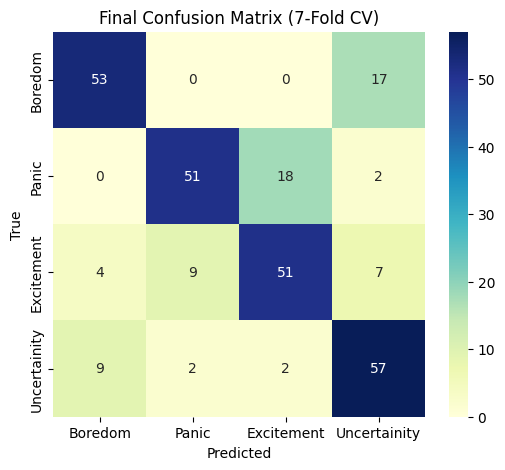

In [ ]:
from torch.utils.data import Subset

#  Load full dataset for K-Fold use
full_dataset = EmotionSequenceDataset(TRAIN_DIR)
num_classes = len(EMOTIONS)

# KFold setup (7-fold)
kf = KFold(n_splits=7, shuffle=True, random_state=42)

#  Track final results
all_preds, all_labels = [], []
fold_metrics = []

print(" Starting 7-Fold Cross Validation")

for fold, (train_idx, val_idx) in enumerate(kf.split(full_dataset)):
    print(f"\n Fold {fold+1}/7")

    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=8)

    model = EnhancedEmotionModel(num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    # Train model on this fold
    for epoch in range(20):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for features, labels in train_loader:
            features, labels = features.to(device), torch.tensor(labels).to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        scheduler.step()
        acc = correct / total
        print(f"Epoch {epoch+1:02d} | Loss: {total_loss:.4f} | Training Accuracy: {acc:.3f}")

    #  Evaluate this fold
    model.eval()
    y_true_fold, y_pred_fold = [], []
    with torch.no_grad():
        for features, labels in val_loader:
            features = features.to(device)
            outputs = model(features)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            y_true_fold.extend(labels)
            y_pred_fold.extend(preds)

    all_labels.extend(y_true_fold)
    all_preds.extend(y_pred_fold)

    # Collect metrics for this fold
    acc = accuracy_score(y_true_fold, y_pred_fold)
    prec = precision_score(y_true_fold, y_pred_fold, average='macro')
    rec = recall_score(y_true_fold, y_pred_fold, average='macro')
    f1 = f1_score(y_true_fold, y_pred_fold, average='macro')

    fold_metrics.append({
        "Fold": fold+1,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    })

#  Summary of All Folds
print("\n Cross-Validation Metrics (Averaged over 7 folds):")
df_results = pd.DataFrame(fold_metrics)
display(df_results.round(3))
print("Mean Accuracy :", round(df_results['Accuracy'].mean(), 3))
print("Mean Precision:", round(df_results['Precision'].mean(), 3))
print("Mean Recall   :", round(df_results['Recall'].mean(), 3))
print("Mean F1 Score :", round(df_results['F1'].mean(), 3))

#  Final Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, xticklabels=EMOTIONS, yticklabels=EMOTIONS, fmt='d', cmap='YlGnBu')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Final Confusion Matrix (7-Fold CV)")
plt.show()
